In [ ]:
import os 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### Data Cleaning :

In [ ]:
df = pd.read_csv("/content/train 2.csv")
df.head(5)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [ ]:
df = df.drop_duplicates()

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 34.8 MB


In [ ]:
monthly_sales = df.groupby(pd.Grouper(key='date', freq='M')).sum().reset_index()

In [ ]:
monthly_sales.head(10)

,date,store,item,sales
0,2013-01-31,85250,395250,454904
1,2013-02-28,77000,357000,459417
2,2013-03-31,85250,395250,617382
3,2013-04-30,82500,382500,682274
4,2013-05-31,85250,395250,763242
5,2013-06-30,82500,382500,795597
6,2013-07-31,85250,395250,855922
7,2013-08-31,85250,395250,766761
8,2013-09-30,82500,382500,689907
9,2013-10-31,85250,395250,656587


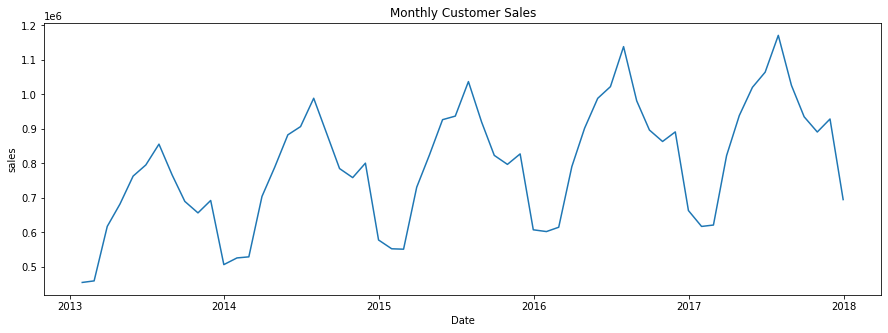

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('sales')
plt.title('Monthly Customer Sales')
plt.show()

In [ ]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales.head(10)

,date,store,item,sales,sales_diff
0,2013-01-31,85250,395250,454904,NaN
1,2013-02-28,77000,357000,459417,4513.0
2,2013-03-31,85250,395250,617382,157965.0
3,2013-04-30,82500,382500,682274,64892.0
4,2013-05-31,85250,395250,763242,80968.0
5,2013-06-30,82500,382500,795597,32355.0
6,2013-07-31,85250,395250,855922,60325.0
7,2013-08-31,85250,395250,766761,-89161.0
8,2013-09-30,82500,382500,689907,-76854.0
9,2013-10-31,85250,395250,656587,-33320.0


In [ ]:
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,store,item,sales,sales_diff
1,2013-02-28,77000,357000,459417,4513.0
2,2013-03-31,85250,395250,617382,157965.0
3,2013-04-30,82500,382500,682274,64892.0
4,2013-05-31,85250,395250,763242,80968.0
5,2013-06-30,82500,382500,795597,32355.0
6,2013-07-31,85250,395250,855922,60325.0
7,2013-08-31,85250,395250,766761,-89161.0
8,2013-09-30,82500,382500,689907,-76854.0
9,2013-10-31,85250,395250,656587,-33320.0
10,2013-11-30,82500,382500,692643,36056.0


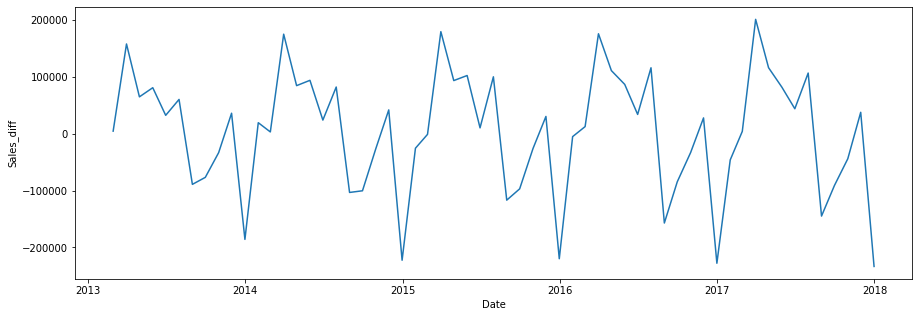

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel('Date')
plt.ylabel('Sales_diff')
plt.show()

In [ ]:
data = monthly_sales.drop(['date', 'item', 'store', 'sales'], axis=1)

In [ ]:
for i in range(1, 13):
  col_name = 'month_' + str(i)
  data[col_name] = data['sales_diff'].shift(i)
data = data.dropna().reset_index(drop=True)
data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0
1,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0
2,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0
3,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0
4,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0
5,100166.0,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0
6,-116949.0,100166.0,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0
7,-97069.0,-116949.0,100166.0,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0
8,-26079.0,-97069.0,-116949.0,100166.0,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0
9,30392.0,-26079.0,-97069.0,-116949.0,100166.0,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0


Split the data into train and test

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sales_diff  35 non-null     float64
 1   month_1     35 non-null     float64
 2   month_2     35 non-null     float64
 3   month_3     35 non-null     float64
 4   month_4     35 non-null     float64
 5   month_5     35 non-null     float64
 6   month_6     35 non-null     float64
 7   month_7     35 non-null     float64
 8   month_8     35 non-null     float64
 9   month_9     35 non-null     float64
 10  month_10    35 non-null     float64
 11  month_11    35 non-null     float64
 12  month_12    35 non-null     float64
dtypes: float64(13)
memory usage: 3.7 KB


In [ ]:
train_data = data[:-3]
test_data = data[-3:]
print('Train Data Shape : ', train_data.shape)
print('Test Data Shape : ', test_data.shape)

Train Data Shape :  (32, 13)
Test Data Shape :  (3, 13)


In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [ ]:
x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print('X_train shape : ', x_train.shape)
print('Y_train shape : ', y_train.shape)
print('X_test shape : ', x_test.shape)
print('Y_test shape : ', y_test.shape)

X_train shape :  (32, 12)
Y_train shape :  (32,)
X_test shape :  (3, 12)
Y_test shape :  (3,)


Make prediction dataframe to merge the predicted sales price of all trained algs

In [ ]:
sales_dates = monthly_sales['date'][-3:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [ ]:
act_sales = monthly_sales['sales'][-3:].to_list()
print(act_sales)

[891160, 928837, 695170]


To create linear regression model and predicted output

In [ ]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pre = lr_model.predict(x_test)

In [ ]:
lr_pre = lr_pre.reshape(-1, 1)
lr_pre_test = np.concatenate([lr_pre, x_test], axis=1)
lr_pre_test = scaler.inverse_transform(lr_pre_test)

In [ ]:
result = []
for i in range(0, len(lr_pre_test)):
  result.append(lr_pre_test[i][0] + act_sales[i])
lr_pre_set = pd.Series(result, name='Linear Prediction')
predict_df = predict_df.merge(lr_pre_set, left_index=True, right_index=True)

In [ ]:
predict_df

,date,Linear Prediction
0,2017-10-31,859885.811474
1,2017-11-30,949817.147354
2,2017-12-31,472689.715246


In [ ]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-3:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-3:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-3:])
print('Linear Regression MSE : ', lr_mse)
print('Linear Regression MAE : ', lr_mae)
print('Linear Regression R2 : ', lr_r2)

Linear Regression MSE :  130276.26869479405
Linear Regression MAE :  91578.20687805908
Linear Regression R2 :  0.603932135836075


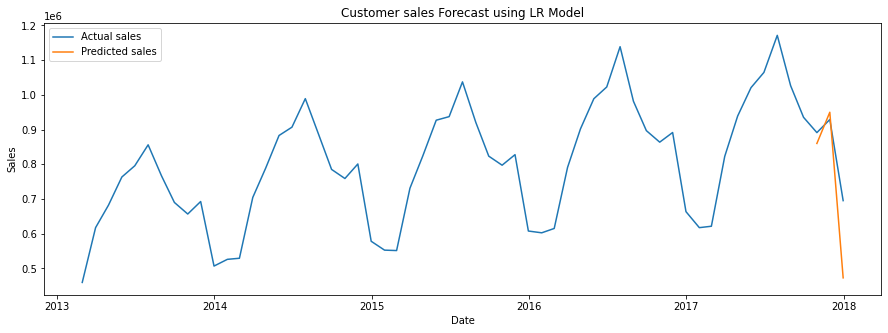

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title('Customer sales Forecast using LR Model')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(['Actual sales', 'Predicted sales'])
plt.show()